In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
import pandas as pd
import os
LOGS = 'logs'
DATA = 'origin_data_csv'
try:
    mort_match = pd.read_csv(os.path.join(LOGS,"mort_match.csv"))
    surv_match = pd.read_csv(os.path.join(LOGS,"surv_match.csv"))
    ICUSTAY = pd.read_csv(os.path.join(DATA,"ICUSTAYS.csv"))
except FileNotFoundError as e:
    print(f"Error: {e}")
    

target_cols = ['SUBJECT_ID','ICUSTAY_ID','HOSPITAL_EXPIRE_FLAG']
patients = pd.concat([mort_match[target_cols],surv_match[target_cols]],axis = 0)
patients = patients.merge(ICUSTAY[['ICUSTAY_ID','LOS']],on='ICUSTAY_ID',how='inner').drop_duplicates()

# LOS : unit day, how long the patient stayed in the ICU
# Turn LOS unit from day in hour
patients['LOS'] = (patients['LOS'] * 24).astype(int)
patients['HOSPITAL_EXPIRE_FLAG'] = patients['HOSPITAL_EXPIRE_FLAG'].astype(bool)
print(patients.head())
patients.to_csv(os.path.join("patients.csv"),index=False)


   SUBJECT_ID  ICUSTAY_ID  HOSPITAL_EXPIRE_FLAG  LOS
0         491      235261                  True   41
1         773      213086                  True  663
2        1049      264612                  True  142
3        2586      258569                  True  351
4        3171      204315                  True   17


Median survival time: 256.0
Median CI approx (lower, upper): (373.0, 195.0)
Top high-risk bins by rate:
   bin_start  bin_end  deaths  at_risk  death_rate
0      140.0    150.0       3       46    0.065217
1      120.0    130.0       2       50    0.040000
2      110.0    120.0       2       55    0.036364
3       60.0     70.0       2       82    0.024390
4      150.0    160.0       1       42    0.023810
5      130.0    140.0       1       47    0.021277
6       40.0     50.0       2       98    0.020408
7       30.0     40.0       2      105    0.019048
8       20.0     30.0       2      124    0.016129
9       10.0     20.0       2      126    0.015873


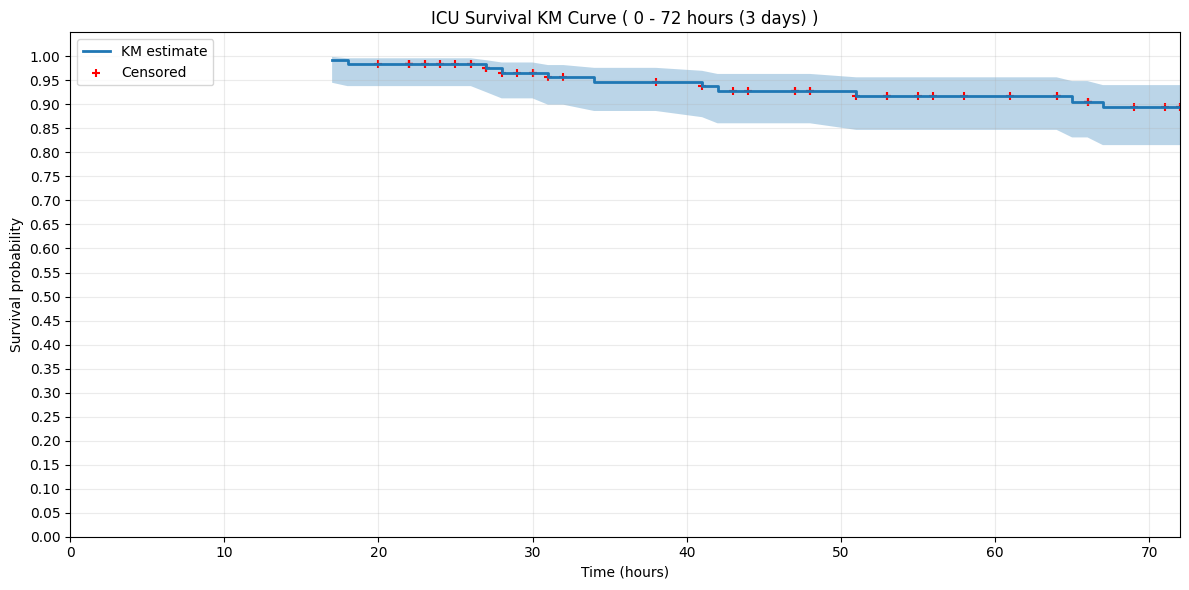

Median survival time: 256.0
Median CI approx (lower, upper): (373.0, 195.0)
Top high-risk bins by rate:
   bin_start  bin_end  deaths  at_risk  death_rate
0      140.0    150.0       3       46    0.065217
1      120.0    130.0       2       50    0.040000
2      110.0    120.0       2       55    0.036364
3       60.0     70.0       2       82    0.024390
4      150.0    160.0       1       42    0.023810
5      130.0    140.0       1       47    0.021277
6       40.0     50.0       2       98    0.020408
7       30.0     40.0       2      105    0.019048
8       20.0     30.0       2      124    0.016129
9       10.0     20.0       2      126    0.015873


<Figure size 640x480 with 0 Axes>

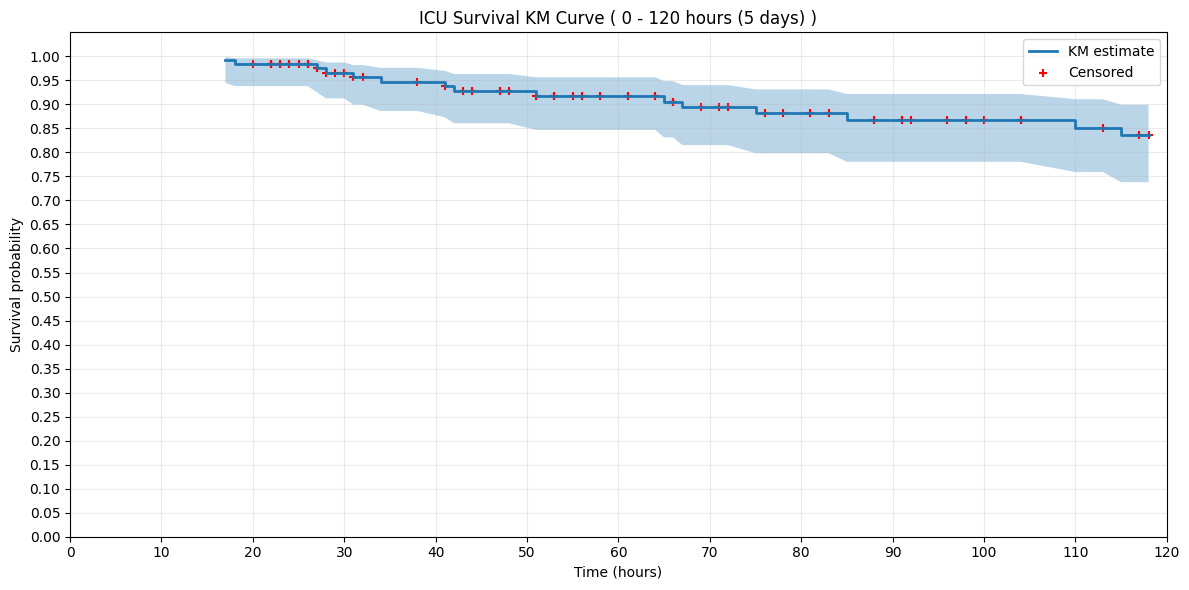

Median survival time: 256.0
Median CI approx (lower, upper): (373.0, 195.0)
Top high-risk bins by rate:
   bin_start  bin_end  deaths  at_risk  death_rate
0      140.0    150.0       3       46    0.065217
1      120.0    130.0       2       50    0.040000
2      110.0    120.0       2       55    0.036364
3       60.0     70.0       2       82    0.024390
4      150.0    160.0       1       42    0.023810
5      130.0    140.0       1       47    0.021277
6       40.0     50.0       2       98    0.020408
7       30.0     40.0       2      105    0.019048
8       20.0     30.0       2      124    0.016129
9       10.0     20.0       2      126    0.015873


<Figure size 640x480 with 0 Axes>

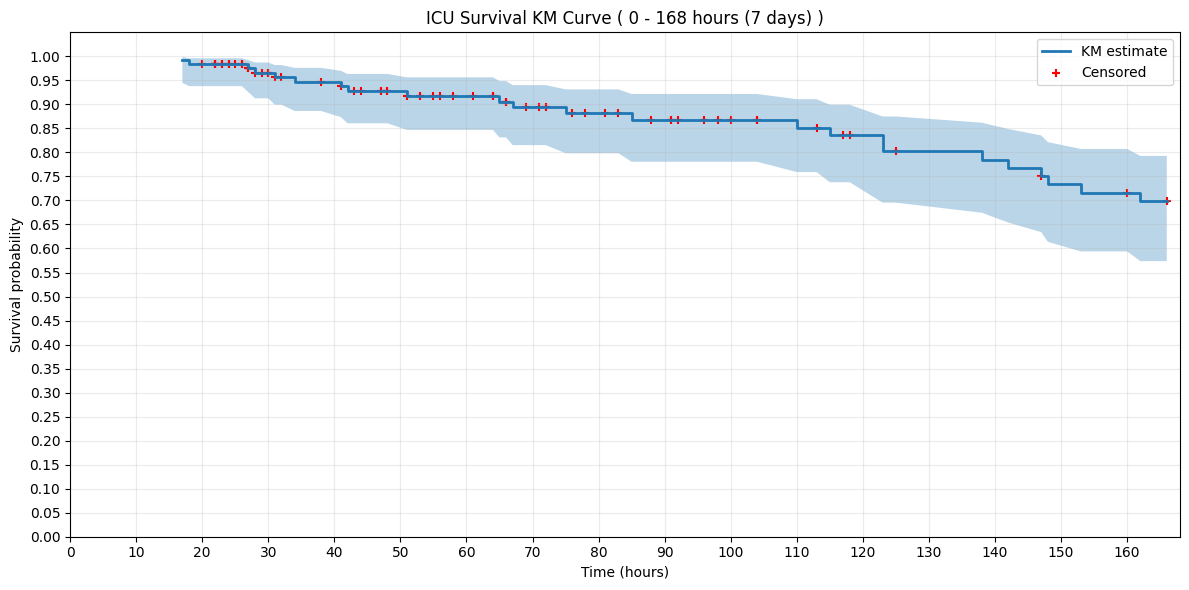

Median survival time: 256.0
Median CI approx (lower, upper): (373.0, 195.0)
Top high-risk bins by rate:
   bin_start  bin_end  deaths  at_risk  death_rate
0      140.0    150.0       3       46    0.065217
1      120.0    130.0       2       50    0.040000
2      110.0    120.0       2       55    0.036364
3       60.0     70.0       2       82    0.024390
4      150.0    160.0       1       42    0.023810
5      130.0    140.0       1       47    0.021277
6       40.0     50.0       2       98    0.020408
7       30.0     40.0       2      105    0.019048
8       20.0     30.0       2      124    0.016129
9       10.0     20.0       2      126    0.015873


<Figure size 640x480 with 0 Axes>

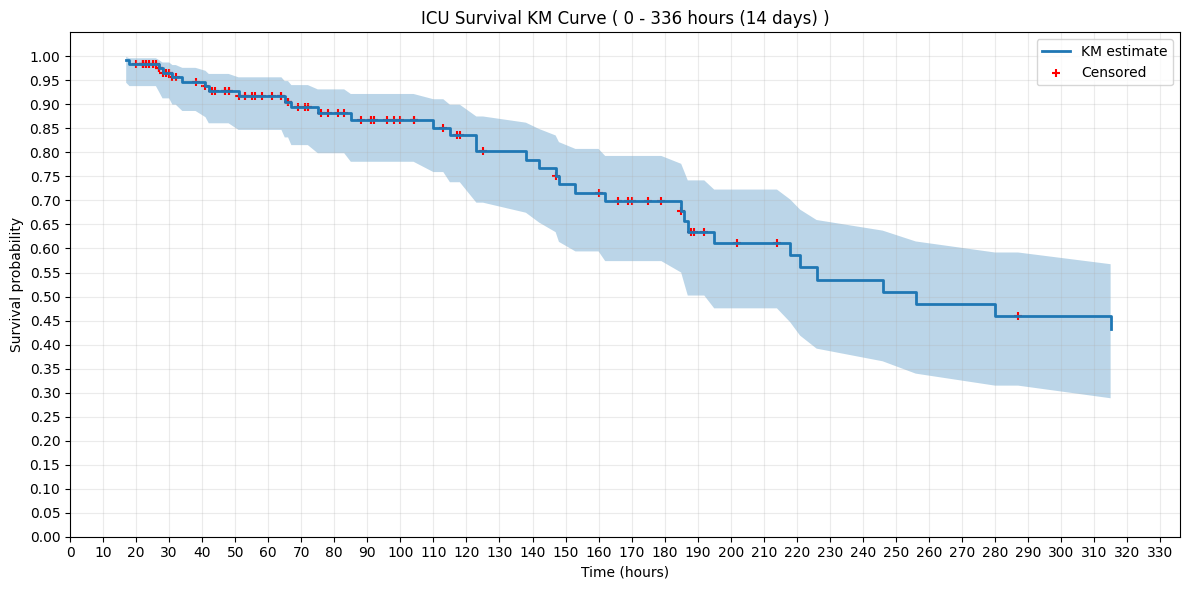

Median survival time: 256.0
Median CI approx (lower, upper): (373.0, 195.0)
Top high-risk bins by rate:
   bin_start  bin_end  deaths  at_risk  death_rate
0      140.0    150.0       3       46    0.065217
1      120.0    130.0       2       50    0.040000
2      110.0    120.0       2       55    0.036364
3       60.0     70.0       2       82    0.024390
4      150.0    160.0       1       42    0.023810
5      130.0    140.0       1       47    0.021277
6       40.0     50.0       2       98    0.020408
7       30.0     40.0       2      105    0.019048
8       20.0     30.0       2      124    0.016129
9       10.0     20.0       2      126    0.015873


<Figure size 640x480 with 0 Axes>

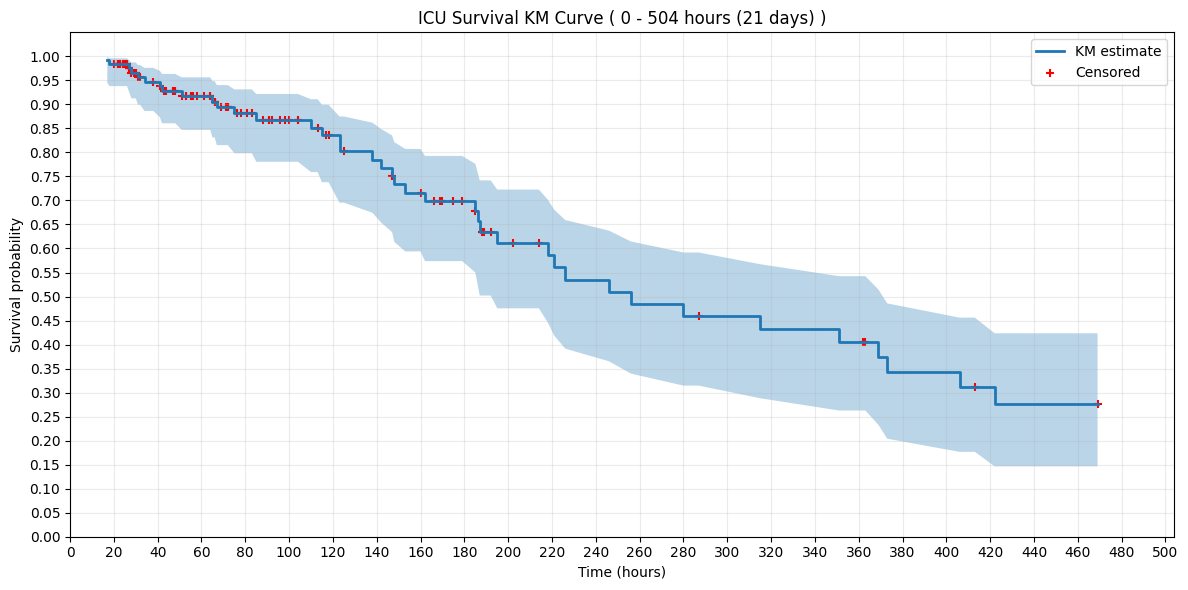

<Figure size 640x480 with 0 Axes>

In [19]:
from sksurv.nonparametric import kaplan_meier_estimator
import matplotlib.pyplot as plt

from typing import Optional, Tuple, Dict, Any

def km_median_and_high_risk(
    times: np.ndarray,
    survival_prob: np.ndarray,
    conf_int: np.ndarray,
    time: Optional[np.ndarray] = None,
    event: Optional[np.ndarray] = None,
    bin_width: float = 5.0,
    top_n: int = 3,
    max_time: Optional[float] = None
) -> Dict[str, Any]:
    """
    Args:
        times, survival_prob, conf_int: 由 kaplan_meier_estimator 回傳的三個陣列。
          - times: 事件發生（或 step points）時間序列
          - survival_prob: 對應 times 的 KM 存活機率
          - conf_int: shape (2, len(times))，分別為 lower, upper
        time, event: (optional) 原始每個樣本的 (time, event_bool) 資料。
          - 若提供，會用來計算每個 bin 的 deaths 與 at-risk，較精確。
          - event 的 True/1 表示發生事件（例如死亡）。
        bin_width: 分段寬度（hours），用來切分高風險時段
        top_n: 顯示前幾個高風險時段
        max_time: 若提供，限制計算區間到此時間（否則用 times.max() 或 time.max()）
    Returns:
        dict 含:
          - 'median_time': 中位存活時間或 None
          - 'median_ci_approx': (lower, upper) 或 (None, None)
          - 'bins_df': DataFrame (每段 deaths/at_risk/rate 或 KM_drop)
          - 'top_bins_by_rate': list of top bins (by rate)
          - 'top_bins_by_count': list of top bins (by raw deaths/count)
    """
    # --- 基本檢查與參數 ---
    times = np.asarray(times)
    survival_prob = np.asarray(survival_prob)
    conf_int = np.asarray(conf_int)
    if max_time is None:
        if time is not None:
            max_time = float(np.nanmax(time))
        else:
            max_time = float(np.nanmax(times)) if times.size>0 else 0.0

    # --- 1) 中位存活時間 (first t where S(t) <= 0.5) ---
    idx_med = np.where(survival_prob <= 0.5)[0]
    if idx_med.size > 0:
        median_time = float(times[idx_med[0]])
    else:
        median_time = None  # 表示中位數超過觀察期或未達到 0.5

    # --- 1b) 以置信區間估計 median 的 rough CI ---
    # 常用做法：用 CI 的上下界分別與 0.5 的交叉時間去近似 median 的上下界
    lower_ci_times = np.where(conf_int[1] <= 0.5)[0]  # upper bound <=0.5 -> lower limit for median
    upper_ci_times = np.where(conf_int[0] <= 0.5)[0]  # lower bound <=0.5 -> upper limit for median
    median_ci_lower = float(times[lower_ci_times[0]]) if lower_ci_times.size>0 else None
    median_ci_upper = float(times[upper_ci_times[0]]) if upper_ci_times.size>0 else None
    median_ci_approx = (median_ci_lower, median_ci_upper)

    # --- 2) 切 bins 並計算死亡密集度 ---
    bins = np.arange(0, max_time + 1e-6, bin_width)  # 左閉右開 [b, b+bin_width)
    bin_starts = bins[:-1]
    bin_ends = bins[1:]

    records = []
    if (time is not None) and (event is not None):
        time = np.asarray(time)
        event = np.asarray(event).astype(bool)
        # 對每個 bin 計算 deaths, at_risk, rate
        for s, e in zip(bin_starts, bin_ends):
            in_bin = (time >= s) & (time < e)
            deaths = int(np.sum(in_bin & event))
            # at_risk 在 bin 起始時刻仍在風險集的個體數：time >= s
            at_risk = int(np.sum(time >= s))
            rate = deaths / at_risk if at_risk > 0 else 0.0
            records.append({
                "bin_start": float(s),
                "bin_end": float(e),
                "deaths": deaths,
                "at_risk": at_risk,
                "death_rate": rate
            })
        bins_df = pd.DataFrame.from_records(records)
        # top by rate & by raw count
        top_by_rate = bins_df.sort_values("death_rate", ascending=False).head(top_n)
        top_by_count = bins_df.sort_values("deaths", ascending=False).head(top_n)

    else:
        # 若沒有原始 time/event，則用 KM 的每次下降量 (prev - curr) 當作「該次事件的相對影響量」
        prev = np.r_[1.0, survival_prob[:-1]]  # KM step 前一個值（假設起點為 1）
        drops = prev - survival_prob  # 每個 times 對應的掉落量（若為 0 表示該 time 沒事件）
        # 將每個 times 的 drop 加總到對應 bin
        for s, e in zip(bin_starts, bin_ends):
            mask = (times >= s) & (times < e)
            drop_sum = float(np.sum(drops[mask]))
            records.append({
                "bin_start": float(s),
                "bin_end": float(e),
                "km_drop_sum": drop_sum
            })
        bins_df = pd.DataFrame.from_records(records)
        # top by drop_sum
        top_by_rate = bins_df.sort_values("km_drop_sum", ascending=False).head(top_n)
        top_by_count = top_by_rate  # same when only have drops

    result = {
        "median_time": median_time,
        "median_ci_approx": median_ci_approx,
        "bins_df": bins_df,
        "top_bins_by_rate": top_by_rate.reset_index(drop=True),
        "top_bins_by_count": top_by_count.reset_index(drop=True),
    }
    return result


def plot_km_curve(df: pd.DataFrame, max_time: int):
    """Plot Kaplan-Meier survival curve, truncated at max_time.
    Args:
        - df (pd.DataFrame): DataFrame containing 'LOS' and 'HOSPITAL_EXPIRE_FLAG' columns.
        - max_time (int): Maximum time to observe.
    """
    event = df['HOSPITAL_EXPIRE_FLAG'].to_numpy().astype(bool)
    time = df['LOS'].to_numpy()

    # KM estimator
    times, survival_prob, conf_int = kaplan_meier_estimator(event, time, conf_type="log-log")

    # KM Analysis
    res = km_median_and_high_risk(
        times, survival_prob, conf_int,
        time=time, event=event,
        bin_width=10, top_n=10, max_time=168
    )

    print("Median survival time:", res["median_time"])
    print("Median CI approx (lower, upper):", res["median_ci_approx"])
    print("Top high-risk bins by rate:")
    print(res["top_bins_by_rate"])

    # 只保留 <= max_time 的部分
    mask = times <= max_time
    times = times[mask]
    survival_prob = survival_prob[mask]
    conf_int = conf_int[:, mask]

    plt.figure(figsize=(12,6))
    plt.step(times, survival_prob, where="post", label="KM estimate", linewidth=2)
    plt.fill_between(times, conf_int[0], conf_int[1], alpha=0.3)

    # 標示 censored (出院存活)
    censored_times = time[~event]
    censored_times = censored_times[censored_times <= max_time]  # 只留在 max_time 內的
    if len(censored_times) > 0:
        idx = np.searchsorted(times, censored_times, side="right") - 1
        idx = idx[idx >= 0]
        plt.scatter(censored_times, survival_prob[idx],
                    marker="+", color="red", label="Censored")

    plt.xlabel("Time (hours)")
    plt.ylabel("Survival probability")
    plt.title(f"ICU Survival KM Curve ( 0 - {max_time} hours ({max_time//24} days) )")
    plt.xlim(0, max_time)
    plt.ylim(0, 1.05)
    plt.yticks(np.arange(0, 1.05, 0.05))
    if max_time <= (14*24):
        plt.xticks(np.arange(0, max_time+1, 10))
    else:
        plt.xticks(np.arange(0, max_time+1, 20))
    plt.legend()
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()
    plt.savefig(f"km_curve_{max_time//24}.png", dpi=300)

observe_time = [3,5,7,14,21]
for time in observe_time:
    max_time = time * 24
    plot_km_curve(patients, max_time=max_time)
